In [18]:
import numpy as np
import sys
sys.path.append("/yezhirui/evo_probe")
from src.find_contact import *
from src.gmm import *
from src.contact_space import *

=== 初始化数据和模型 ===
PDB坐标提取完成: 93 个残基 (链 A)
PDB坐标提取完成: 60 个残基 (链 A)
距离矩阵计算完成: 93 x 93
距离矩阵计算完成: 60 x 60
共同残基数量: 60 个 (原始: 93 vs 60)
关键接触点数量: 244

dataset: ANC0
shape: (1000, 244)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [973  27]
BIC分数: -469178.24

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 19.7300

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-150.5095, 515.5143]

dataset: ANC1
shape: (1000, 244)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [968  32]
BIC分数: -400967.84

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 11.9652

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-68.6043, 234.6003]

dataset: ANC2
shape: (1000, 244)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成
各聚类大小: [985  15]
BIC分数: 65042.54

步骤2: 提取聚类中心点...
中心A形状: (244,)
中心B形状: (244,)
投影向量V形状: (244,)
投影向量V模长: 17.9522

步骤3: 投影数据到一维...
投影后数据形状: (1000,)
投影数据范围: [-93.1752, 418.0281]

dataset: ANC3
shape: (1000, 244)
=== 基于GMM指导的投影 (k=2) ===
步骤1: 拟合GMM模型...
GMM拟合完成

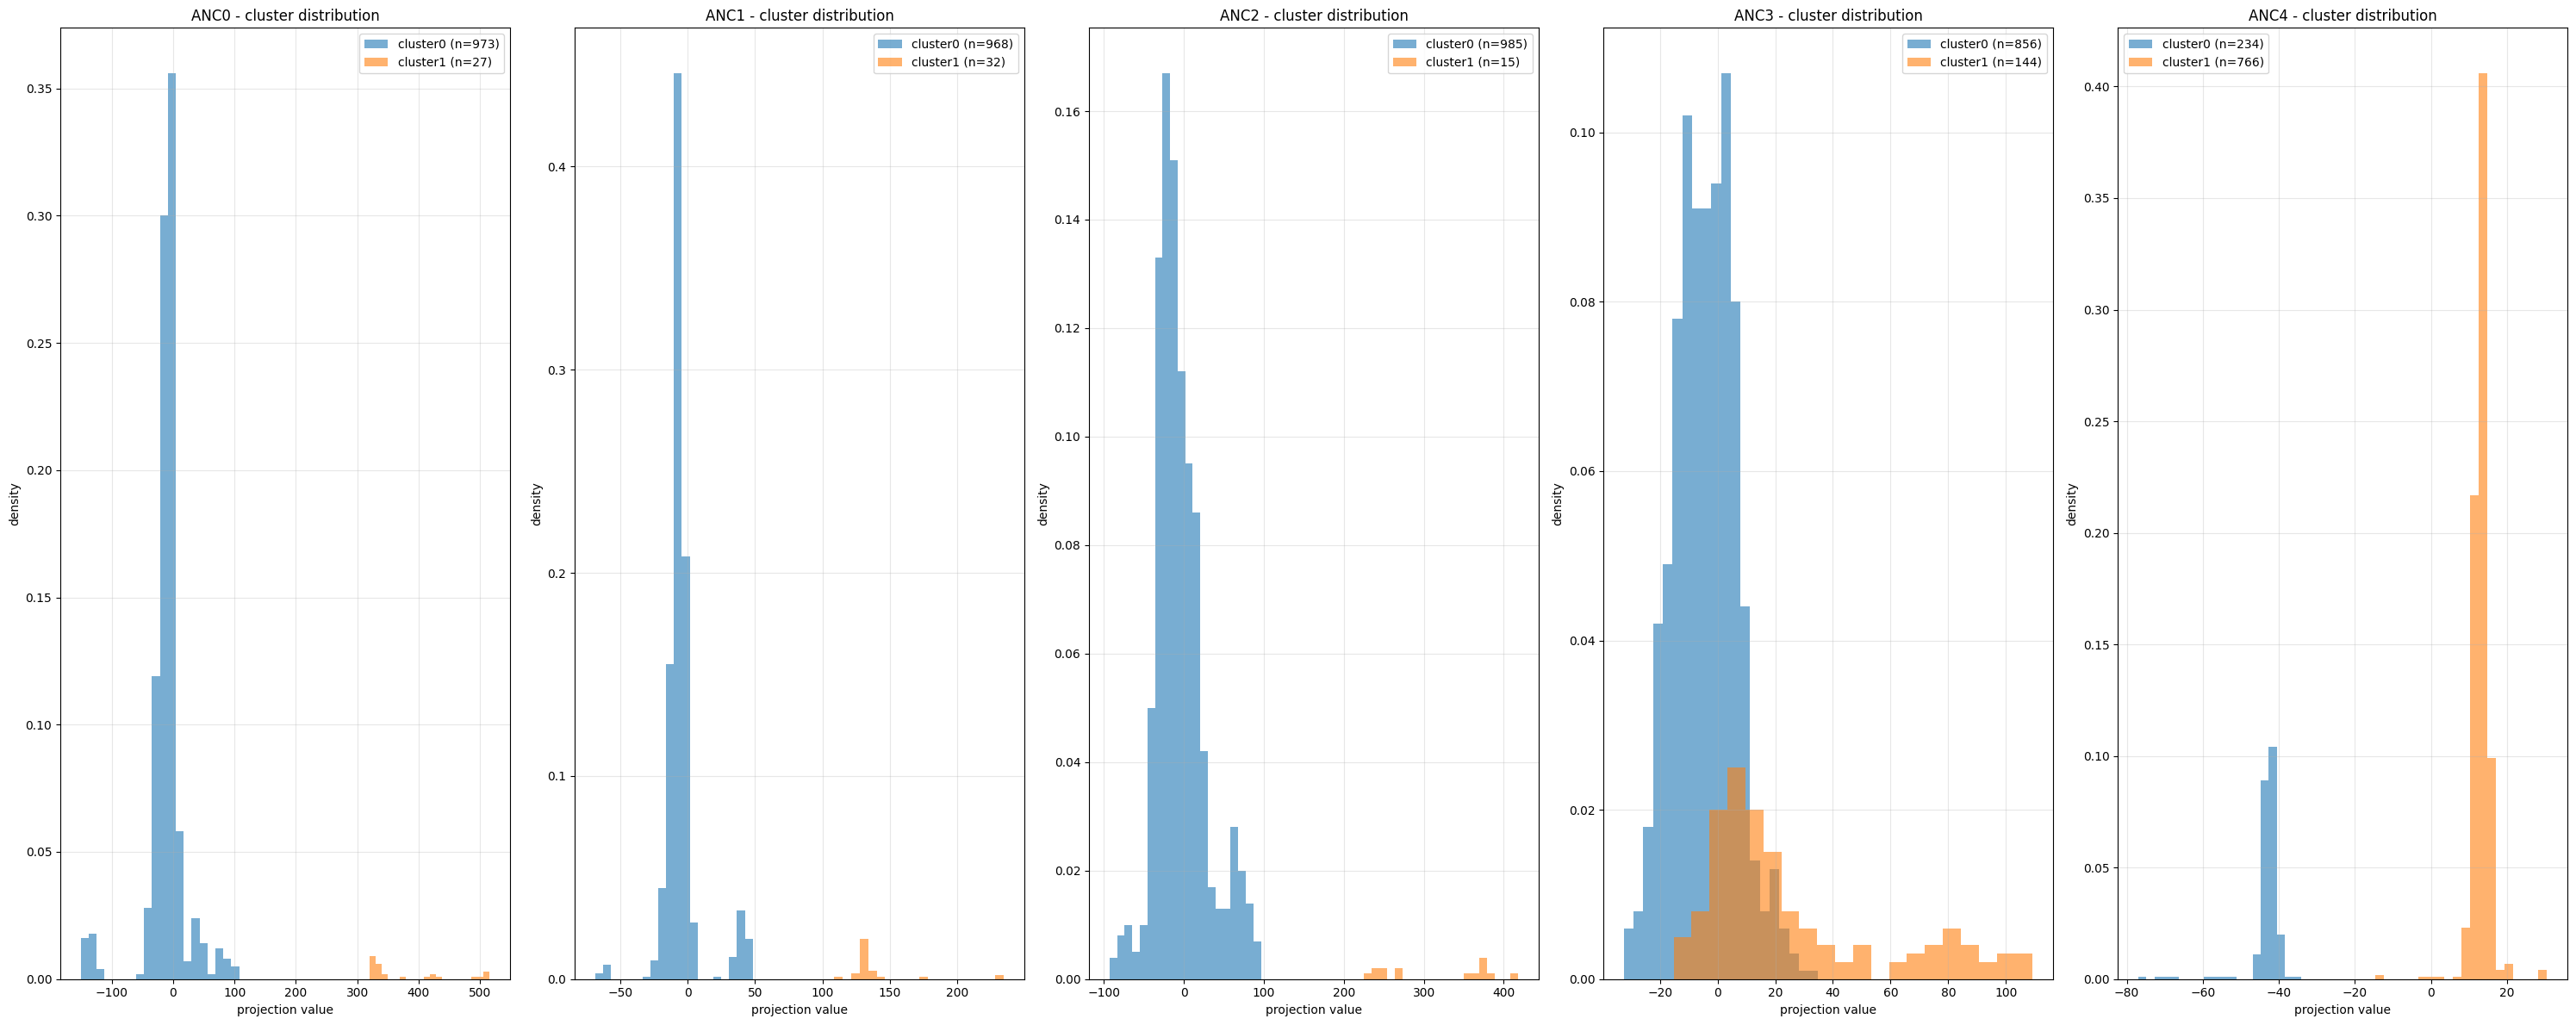

In [19]:
print("=== 初始化数据和模型 ===")

# 1. 获取关键接触点
chemokine_pdb = "1j8i"  # 趋化因子折叠
alternate_pdb = "2jp1"  # 替代折叠xw
results = calculate_contact_difference(chemokine_pdb, alternate_pdb,threshold=10.0,remove_diag=5)
critical_contacts = results['critical_contacts']
print(f"关键接触点数量: {len(critical_contacts)}")

# 2. 加载MJ矩阵
mj_dict = load_mj_matrix("/yezhirui/evo_probe/data/mj_matrix.txt")

# 3. 生成contact embedding

contact_space = ContactSpace(critical_contacts, mj_dict)

# 批量添加节点
path_dir = "/yezhirui/evo_probe/data/sample"
node_configs = [("ANC0", f"{path_dir}/node499_anc0_samples.fasta"),("ANC1", f"{path_dir}/node500_anc1_samples.fasta"),
("ANC2", f"{path_dir}/node501_anc2_samples.fasta"), ("ANC3", f"{path_dir}/node502_anc3_samples.fasta"), ("ANC4", f"{path_dir}/node507_anc4_samples.fasta")]
for node_id, fasta_path in node_configs:
    contact_space.add_node_from_fasta(node_id, fasta_path)

contact_space.build_embeddings()

anc0_contact_embedding = contact_space.get_node_embeddings("ANC0")
anc1_contact_embedding = contact_space.get_node_embeddings("ANC1")
anc2_contact_embedding = contact_space.get_node_embeddings("ANC2")
anc3_contact_embedding = contact_space.get_node_embeddings("ANC3")
anc4_contact_embedding = contact_space.get_node_embeddings("ANC4")



datasets = {
    'ANC0': anc0_contact_embedding,
    'ANC1': anc1_contact_embedding,
    'ANC2': anc2_contact_embedding,
    'ANC3': anc3_contact_embedding,
    'ANC4': anc4_contact_embedding
}

all_results = compare_gmm_guided_projections(
    datasets,
    k=2,
    figsize=(30, 12)
)

anc0_results = all_results['ANC0']
anc1_results = all_results['ANC1']
anc2_results = all_results['ANC2']
anc3_results = all_results['ANC3']
anc4_results = all_results['ANC4']

In [20]:
anc0_cov = anc0_results['covariances']
anc1_cov = anc1_results['covariances']
anc2_cov = anc2_results['covariances']
anc3_cov = anc3_results['covariances']
anc4_cov = anc4_results['covariances']



In [21]:
import numpy as np

def covariance_to_correlation(covariance_matrix):
    """
    将协方差矩阵转换为相关系数矩阵
    
    Args:
        covariance_matrix: 协方差矩阵 (n_features, n_features)
        
    Returns:
        correlation_matrix: 相关系数矩阵 (n_features, n_features)
    """
    # 获取对角线元素（方差）
    variances = np.diag(covariance_matrix)
    
    # 计算标准差
    std_devs = np.sqrt(variances)
    
    # 避免除零错误
    std_devs = np.where(std_devs == 0, 1e-10, std_devs)
    
    # 计算相关系数矩阵
    correlation_matrix = covariance_matrix / np.outer(std_devs, std_devs)
    
    return correlation_matrix

def batch_covariance_to_correlation(covariances_list):
    """
    批量将协方差矩阵列表转换为相关系数矩阵列表
    
    Args:
        covariances_list: 协方差矩阵列表，每个元素形状为 (n_components, n_features, n_features)
        
    Returns:
        correlations_list: 相关系数矩阵列表
    """
    correlations_list = []
    
    for covariances in covariances_list:
        # covariances 的形状是 (n_components, n_features, n_features)
        correlations = []
        
        for i in range(covariances.shape[0]):  # 遍历每个聚类
            cov_matrix = covariances[i]
            corr_matrix = covariance_to_correlation(cov_matrix)
            correlations.append(corr_matrix)
        
        correlations_list.append(np.array(correlations))
    
    return correlations_list



all_covariances = [ anc2_cov, anc3_cov, anc4_cov]
all_correlations = batch_covariance_to_correlation(all_covariances)


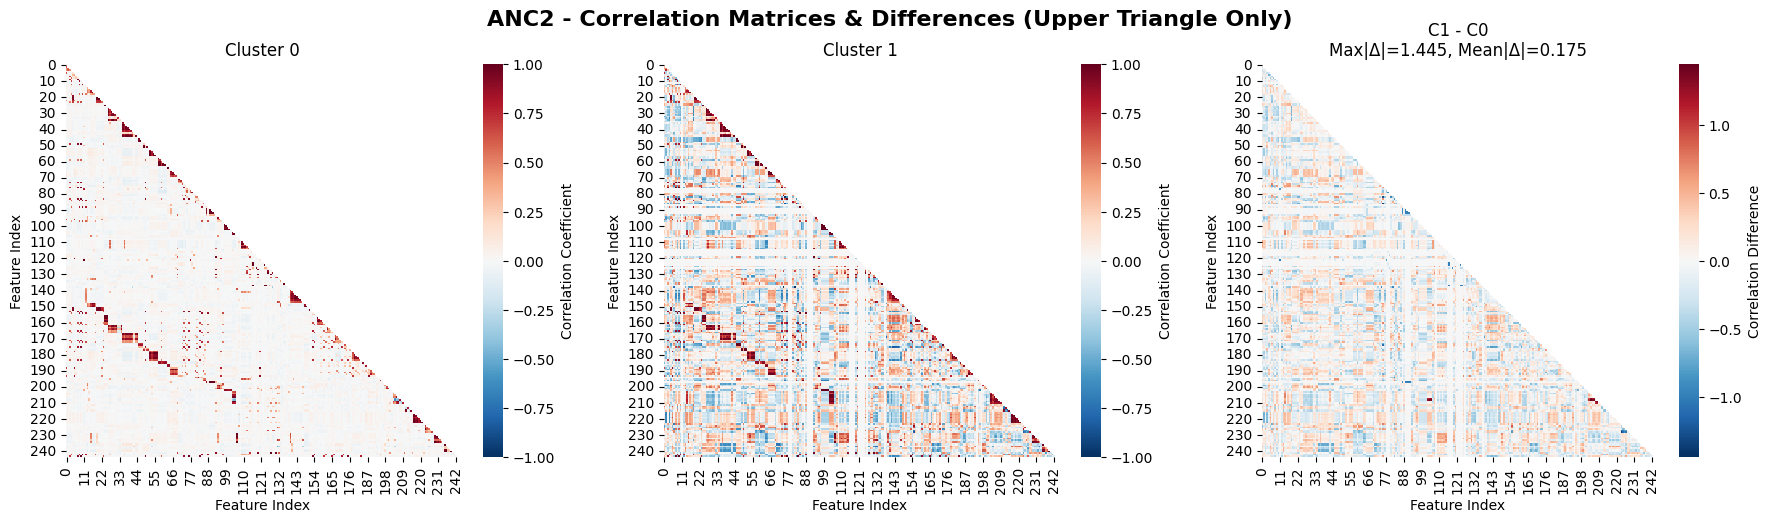

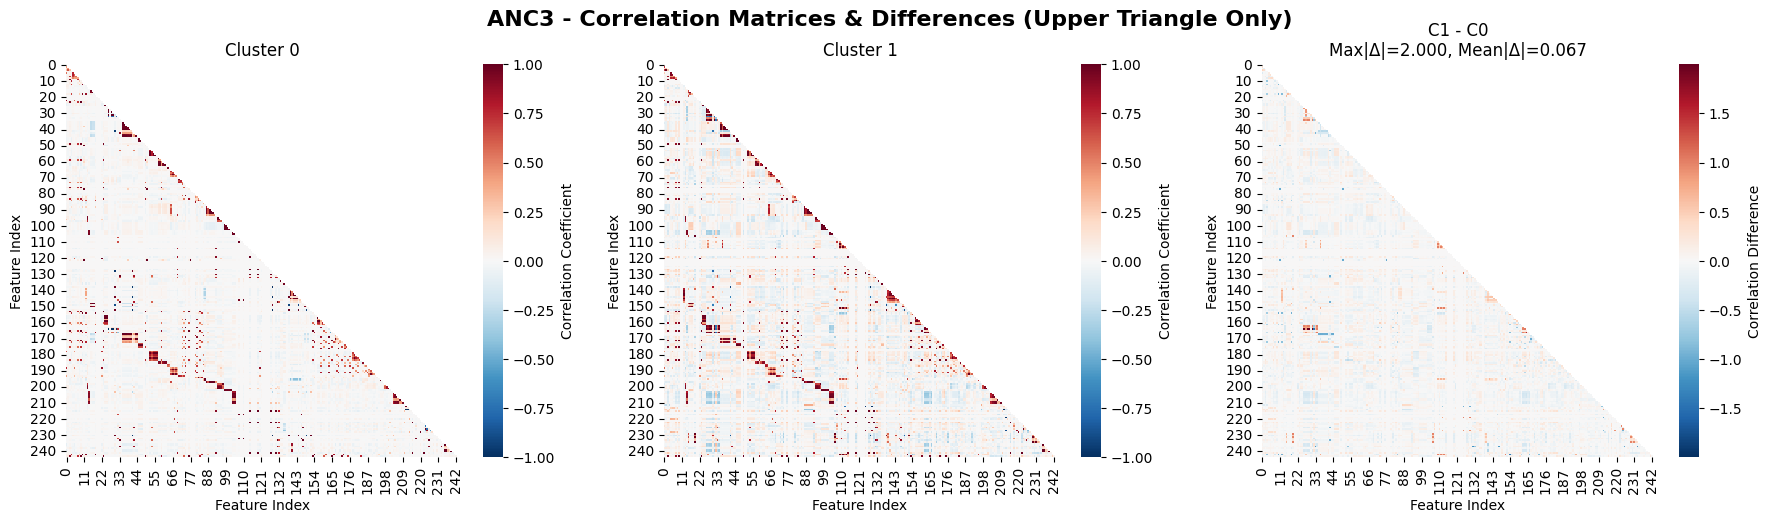

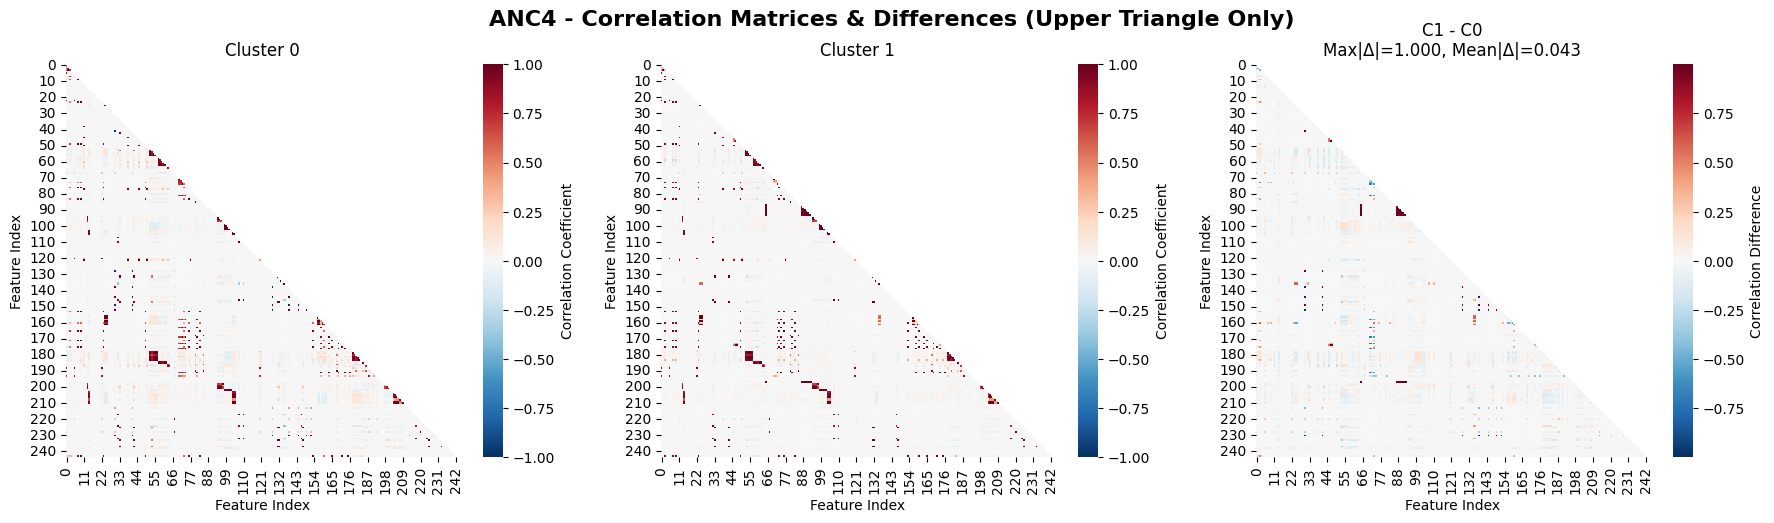

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_correlation_matrices(all_correlations, dataset_names=None, show_difference=True, reference_cluster=0):
    """
    可视化相关系数矩阵，只显示下三角（不包含对角线）
    """
    if dataset_names is None:
        dataset_names = [f'ANC{i}' for i in range(len(all_correlations))]
    
    n_datasets = len(all_correlations)
    
    for dataset_idx, (corr_matrices, name) in enumerate(zip(all_correlations, dataset_names)):
        n_clusters = corr_matrices.shape[0]
        
        n_plots = n_clusters
        if show_difference and n_clusters > 1:
            n_plots += (n_clusters - 1)
        
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        if show_difference and n_clusters > 1:
            fig.suptitle(f'{name} - Correlation Matrices & Differences (Upper Triangle Only)', 
                        fontsize=16, fontweight='bold')
        else:
            fig.suptitle(f'{name} - Correlation Matrices (Upper Triangle Only)', fontsize=16, fontweight='bold')
        
        plot_idx = 0
        
        # 绘制原始相关系数矩阵
        for cluster_idx in range(n_clusters):
            corr_matrix = corr_matrices[cluster_idx].copy()
            
            # 创建掩码：掩盖上三角和对角线
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
            
            sns.heatmap(corr_matrix, 
                       mask=mask,
                       cmap='RdBu_r',
                       center=0,
                       vmin=-1, vmax=1,
                       square=True,
                       cbar_kws={'label': 'Correlation Coefficient'},
                       ax=axes[plot_idx])
            
            axes[plot_idx].set_title(f'Cluster {cluster_idx}')
            axes[plot_idx].set_xlabel('Feature Index')
            axes[plot_idx].set_ylabel('Feature Index')
            plot_idx += 1
        
        # 绘制差异热力图
        if show_difference and n_clusters > 1:
            reference_matrix = corr_matrices[reference_cluster]
            
            for cluster_idx in range(n_clusters):
                if cluster_idx == reference_cluster:
                    continue
                    
                difference_matrix = (corr_matrices[cluster_idx] - reference_matrix).copy()
                
                # 掩盖上三角和对角线
                mask = np.triu(np.ones_like(difference_matrix, dtype=bool), k=0)
                
                # 统计信息（只考虑下三角，不含对角线）
                non_diag_upper = np.triu(difference_matrix, k=1)
                max_diff = np.abs(non_diag_upper).max()
                mean_abs_diff = np.abs(non_diag_upper[non_diag_upper != 0]).mean()
                
                sns.heatmap(difference_matrix, 
                           mask=mask,
                           cmap='RdBu_r',
                           center=0,
                           vmin=-max_diff, vmax=max_diff,
                           square=True,
                           cbar_kws={'label': 'Correlation Difference'},
                           ax=axes[plot_idx])
                
                axes[plot_idx].set_title(f'C{cluster_idx} - C{reference_cluster}\n'
                                       f'Max|Δ|={max_diff:.3f}, Mean|Δ|={mean_abs_diff:.3f}')
                axes[plot_idx].set_xlabel('Feature Index')
                axes[plot_idx].set_ylabel('Feature Index')
                plot_idx += 1
        
        plt.tight_layout()
        plt.show()

# 使用修改后的函数
dataset_names = ['ANC2', 'ANC3', 'ANC4']

# 显示原始矩阵和差异矩阵
visualize_correlation_matrices(all_correlations, dataset_names, show_difference=True, reference_cluster=0)

# 如果只想看原始矩阵（和之前一样）
# visualize_correlation_matrices(all_correlations, dataset_names, show_difference=False)

In [23]:
def find_most_different_correlations(all_correlations, dataset_names=None, 
                                   reference_cluster=0, top_k=5):
    """
    找出差异最大的特征对
    """
    if dataset_names is None:
        dataset_names = [f'ANC{i}' for i in range(len(all_correlations))]
    
    print("=== 差异最大的特征对分析 ===")
    
    for dataset_idx, (corr_matrices, name) in enumerate(zip(all_correlations, dataset_names)):
        n_clusters = corr_matrices.shape[0]
        
        if n_clusters < 2:
            continue
            
        print(f"\n{name}:")
        
        reference_matrix = corr_matrices[reference_cluster]
        
        for cluster_idx in range(n_clusters):
            if cluster_idx == reference_cluster:
                continue
                
            difference_matrix = corr_matrices[cluster_idx] - reference_matrix
            n_features = difference_matrix.shape[0]
            
            # 收集所有差异及其位置
            differences_with_positions = []
            for i in range(n_features):
                for j in range(i+1, n_features):  # 只考虑上三角
                    diff = difference_matrix[i, j]
                    differences_with_positions.append((abs(diff), diff, i, j))
            
            # 按绝对差异排序
            differences_with_positions.sort(reverse=True)
            
            print(f"  C{cluster_idx} - C{reference_cluster} 差异最大的{top_k}对特征:")
            for rank, (abs_diff, diff, i, j) in enumerate(differences_with_positions[:top_k]):
                ref_corr = reference_matrix[i, j]
                curr_corr = corr_matrices[cluster_idx][i, j]
                print(f"    {rank+1}. 特征({i},{j}): Δ={diff:+.4f} "
                      f"(C{reference_cluster}={ref_corr:.4f} → C{cluster_idx}={curr_corr:.4f})")

find_most_different_correlations(all_correlations, dataset_names, reference_cluster=0, top_k=5)

=== 差异最大的特征对分析 ===

ANC2:
  C1 - C0 差异最大的5对特征:
    1. 特征(204,208): Δ=+1.4445 (C0=-0.6391 → C1=0.8054)
    2. 特征(105,208): Δ=+1.4305 (C0=-0.4436 → C1=0.9869)
    3. 特征(223,228): Δ=-1.3741 (C0=0.5850 → C1=-0.7891)
    4. 特征(104,208): Δ=+1.3611 (C0=-0.4552 → C1=0.9060)
    5. 特征(206,208): Δ=+1.3547 (C0=-0.4431 → C1=0.9116)

ANC3:
  C1 - C0 差异最大的5对特征:
    1. 特征(28,164): Δ=+1.9999 (C0=-0.9999 → C1=1.0000)
    2. 特征(26,164): Δ=+1.9997 (C0=-0.9997 → C1=1.0000)
    3. 特征(29,164): Δ=+1.9997 (C0=-0.9997 → C1=1.0000)
    4. 特征(31,164): Δ=+1.9988 (C0=-0.9988 → C1=1.0000)
    5. 特征(164,166): Δ=+1.5339 (C0=-0.5339 → C1=1.0000)

ANC4:
  C1 - C0 差异最大的5对特征:
    1. 特征(128,149): Δ=-1.0000 (C0=1.0000 → C1=0.0000)
    2. 特征(149,230): Δ=+1.0000 (C0=-1.0000 → C1=-0.0000)
    3. 特征(149,152): Δ=+1.0000 (C0=-1.0000 → C1=0.0000)
    4. 特征(144,149): Δ=+1.0000 (C0=-1.0000 → C1=0.0000)
    5. 特征(128,230): Δ=+1.0000 (C0=-1.0000 → C1=-0.0000)


如果两个接触之间的关系变化超过了阈值，就在它们对应的节点间画一条连线，用颜色和粗细来表示变化的性质和强度：

红色线: 协同性显著增强。

蓝色线: 补偿性显著增强或协同性显著减弱。

线的粗细: 代表关系变化的剧烈程度。

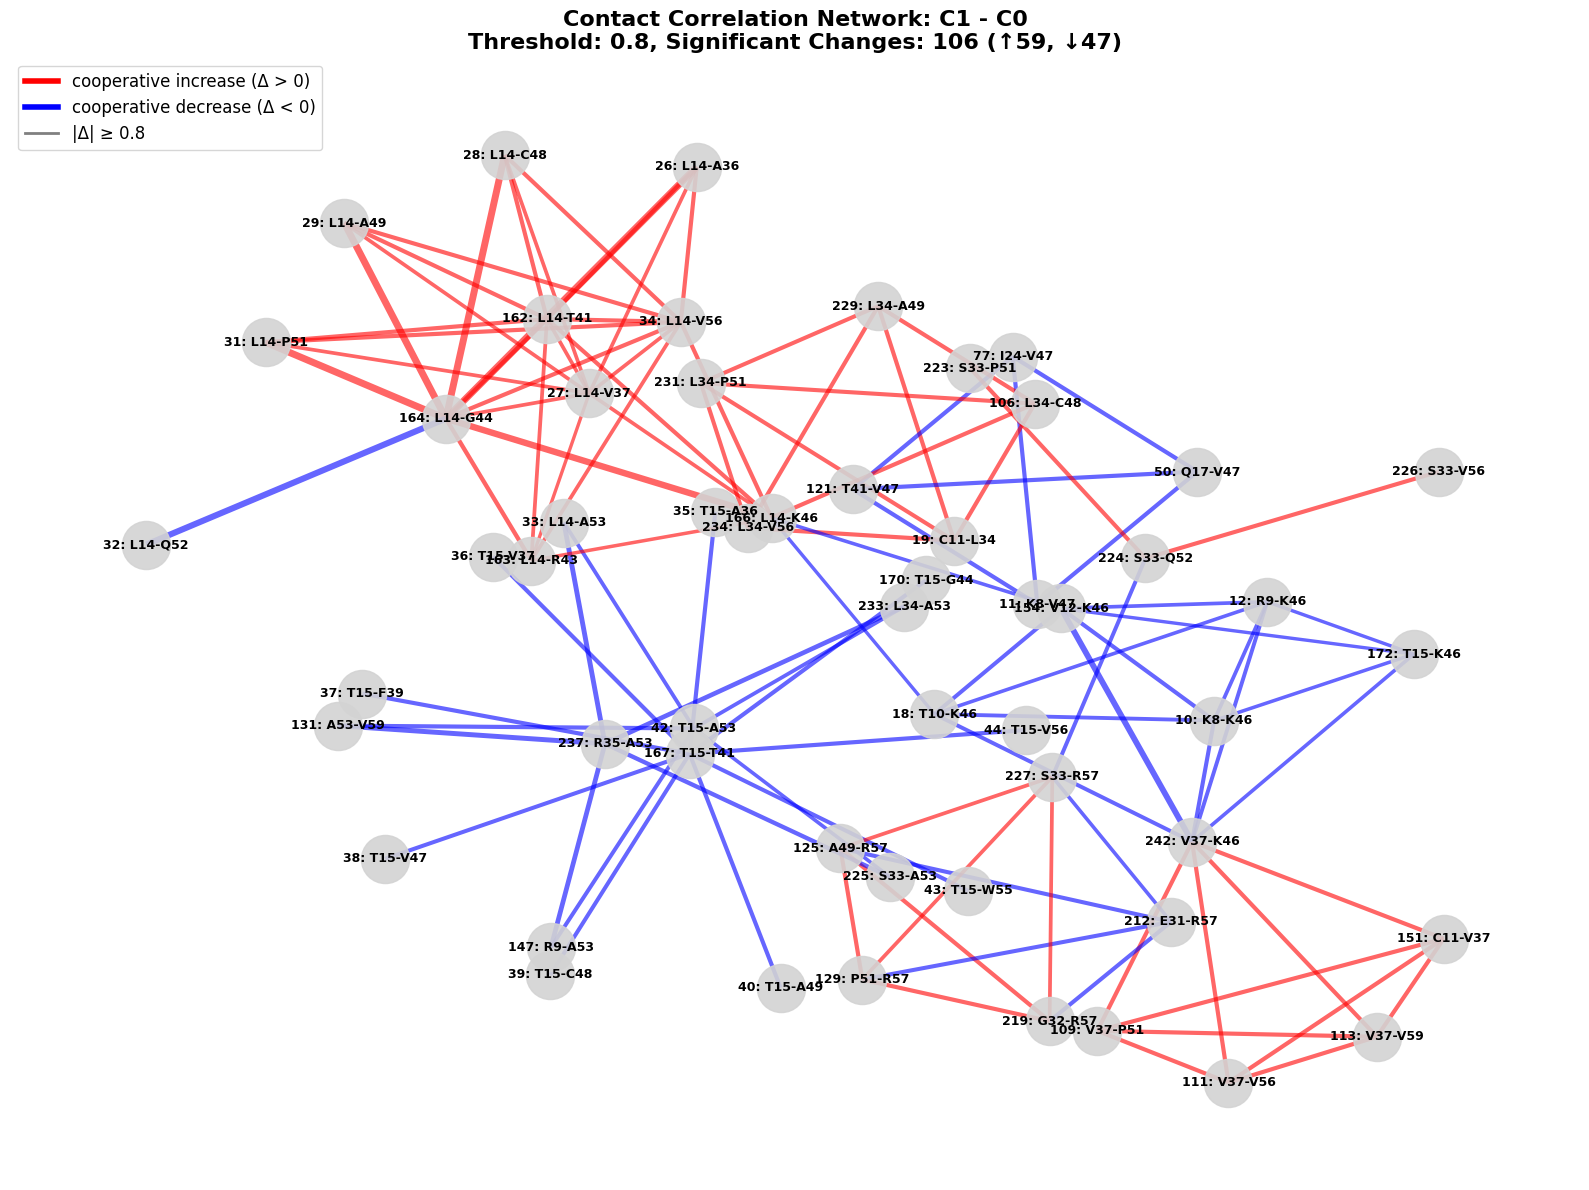

In [ ]:
import networkx as nx

def network_plot_with_residues(corr_matrices, contact_list, residue_types, 
                                     cluster_a=0, cluster_b=1, threshold=0.5,show_index=False):
 
    diff_matrix = corr_matrices[cluster_b] - corr_matrices[cluster_a]
    n_features = diff_matrix.shape[0]
   
    
    # contact_labels = [get_contact_info(contact_list, i, residue_types) for i in range(len(contact_list))]
    if show_index:
        contact_labels = [
            f"{i}: {get_contact_info(contact_list, i, residue_types)}"
            for i in range(n_features)
        ]
    else:
        contact_labels = [
            get_contact_info(contact_list, i, residue_types)
            for i in range(n_features)
        ]
    edges, colors, widths = [], [], []
    
    for i in range(len(contact_labels)):
        for j in range(i + 1, len(contact_labels)):
            if abs(diff_matrix[i, j]) >= threshold:
                edges.append((contact_labels[i], contact_labels[j]))
                colors.append('red' if diff_matrix[i, j] > 0 else 'blue')
                widths.append(min(5, max(1, abs(diff_matrix[i, j]) * 3)))


    
    G = nx.Graph()
    
    G.add_edges_from(edges)
  
    
    # 使用更好的布局
    # pos = nx.spring_layout(G, k=3, iterations=100, seed=42)
    pos = nx.kamada_kawai_layout(G)
    
    plt.figure(figsize=(16, 12))
    
    # 绘制边
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, 
                          width=widths, alpha=0.6)
    
    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', 
                          node_size=1200, alpha=0.9)
    
    # 绘制节点标签
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold')
    # nx.draw_networkx_labels(G, pos, labels=contact_labels, 
    #                        font_size=9, font_weight='bold')
    
    n_positive = sum(1 for c in colors if c == 'red')
    n_negative = sum(1 for c in colors if c == 'blue')
    
    plt.title(f'Contact Correlation Network: C{cluster_b} - C{cluster_a}\n'
              f'Threshold: {threshold}, Significant Changes: {len(edges)} (↑{n_positive}, ↓{n_negative})', 
              fontsize=16, fontweight='bold')
    
    # 图例
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=4, label='cooperative increase (Δ > 0)'),
        Line2D([0], [0], color='blue', lw=4, label='cooperative decrease (Δ < 0)'),
        Line2D([0], [0], color='gray', lw=2, label=f'|Δ| ≥ {threshold}')
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
 


network_plot_with_residues(
    all_correlations[1], critical_contacts,  results['alternate_residue_types'],
    cluster_a=0, cluster_b=1, threshold=0.8,show_index=True
)

In [55]:
results['alternate_residue_types']

{1: 'V',
 2: 'G',
 3: 'S',
 4: 'E',
 5: 'V',
 6: 'S',
 7: 'D',
 8: 'K',
 9: 'R',
 10: 'T',
 11: 'C',
 12: 'V',
 13: 'S',
 14: 'L',
 15: 'T',
 16: 'T',
 17: 'Q',
 18: 'R',
 19: 'L',
 20: 'P',
 21: 'V',
 22: 'S',
 23: 'R',
 24: 'I',
 25: 'K',
 26: 'T',
 27: 'Y',
 28: 'T',
 29: 'I',
 30: 'T',
 31: 'E',
 32: 'G',
 33: 'S',
 34: 'L',
 35: 'R',
 36: 'A',
 37: 'V',
 38: 'I',
 39: 'F',
 40: 'I',
 41: 'T',
 42: 'K',
 43: 'R',
 44: 'G',
 45: 'L',
 46: 'K',
 47: 'V',
 48: 'C',
 49: 'A',
 50: 'D',
 51: 'P',
 52: 'Q',
 53: 'A',
 54: 'T',
 55: 'W',
 56: 'V',
 57: 'R',
 58: 'D',
 59: 'V',
 60: 'V'}

In [51]:
i, j = 224, 226
print(f"ANC3 C0 位置({i},{j}): {all_correlations[1][0][i, j]:.4f}")
print(f"ANC3 C1 位置({i},{j}): {all_correlations[1][1][i, j]:.4f}")
print(f"差异: {all_correlations[1][1][i, j] - all_correlations[1][0][i, j]:.4f}")

ANC3 C0 位置(224,226): -0.7532
ANC3 C1 位置(224,226): 0.2377
差异: 0.9909


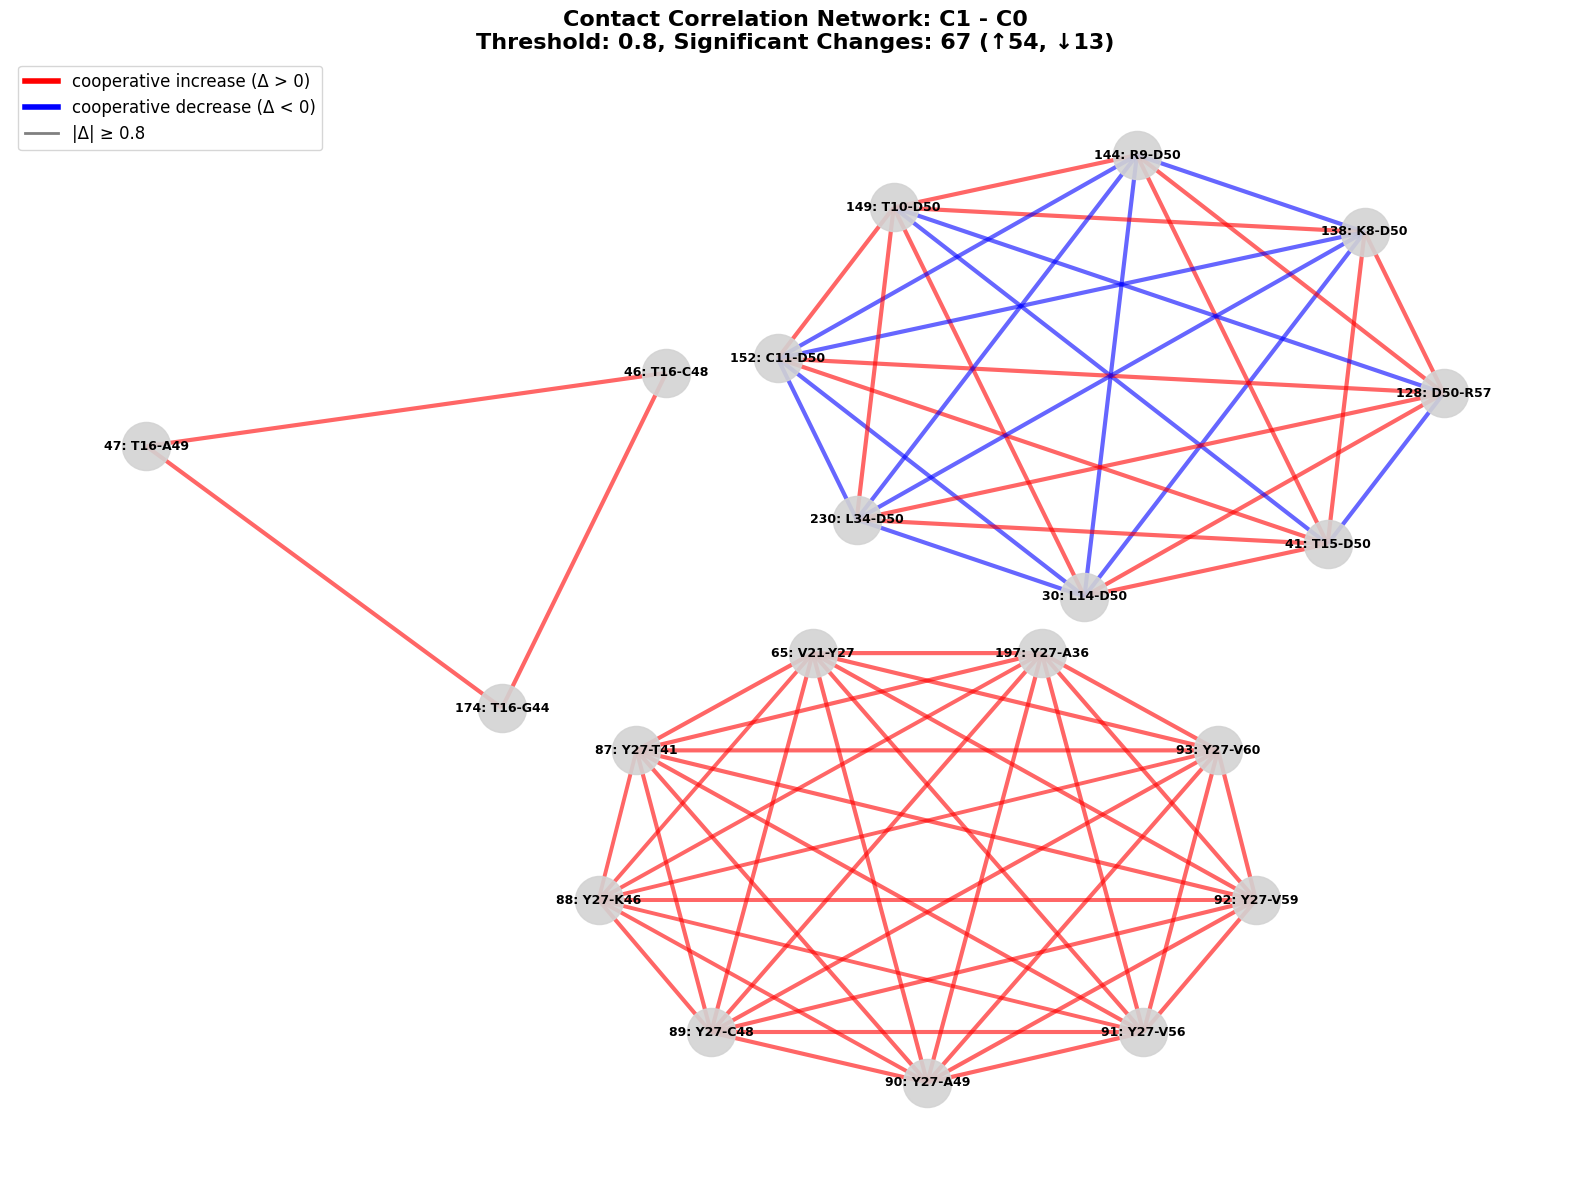

In [52]:
#anc4

network_plot_with_residues(
    all_correlations[2], critical_contacts,  results['alternate_residue_types'],
    cluster_a=0, cluster_b=1, threshold=0.8,show_index=True
)